# Models for price forecasting

## Random Forest

In the mid season check we got to a model able to predict price based on performance with a very decent accuracy. However, for a model to be functional as a real life predictor, it requies the price not to be only described by a state of the form

$\text{Price} = f(\text{Average, GP, Home}) + \epsilon \text{ Team},$

but by one that also takes information about the recent price itself to predict the price in the future:

$\text{Price} _t = f(\text{State} _t) + g(\text{Price} _{t-1}) + h(\text{Price} _{t-2}) + ... ,$
 
where $\text{State}_t$ corresponds to the current "frozen" performance statistics, the team, and other price-based features, such as volatility. This will capture more subtle effects on the market, such as opinion, transfer rumours, ...

Let's bring back our cleansed dataset:

In [1]:
import pandas as pd
df = pd.read_csv("all_data.csv")

#Players who have played below the GP average of the dataset
below_avg_GP = (
    df.groupby("Player")["GP"]
      .max()
      .loc[lambda x: x < 4]
      .index
      .tolist()
)

df = df[~df["Player"].isin(below_avg_GP)]

#Rows before the season started
df["Date"] = pd.to_datetime(df["Date"])
df = df[df["Date"] > "15-08-2025"]
df.shape

(12035, 10)

Now, I'll create three new features: `Price_lag1`, `Price _lag2`, `Price_lag3`, `Price_lag4`, and `Price_lag5`, one for each time regression. Let's see how many rows without NA's are available after this.

In [2]:
df_t = df.sort_values(['Player', 'Date'])

# Price lags
df_t['Price_lag1'] = df_t.groupby('Player')['Price'].shift(1)
df_t['Price_lag2'] = df_t.groupby('Player')['Price'].shift(2)
df_t['Price_lag3'] = df_t.groupby('Player')['Price'].shift(3)
df_t['Price_lag4'] = df_t.groupby('Player')['Price'].shift(4)
df_t['Price_lag5'] = df_t.groupby('Player')['Price'].shift(5)

# Date lags
df_t['Date_lag1'] = df_t['Date'].shift(1)
df_t['Date_lag2'] = df_t['Date'].shift(2)
df_t['Date_lag3'] = df_t['Date'].shift(3)
df_t['Date_lag4'] = df_t['Date'].shift(4)
df_t['Date_lag5'] = df_t['Date'].shift(5)

# Day differences
df_t['d_lag1'] = (df_t['Date'] - df_t['Date_lag1']).dt.days
df_t['d_lag2'] = (df_t['Date'] - df_t['Date_lag2']).dt.days
df_t['d_lag3'] = (df_t['Date'] - df_t['Date_lag3']).dt.days
df_t['d_lag4'] = (df_t['Date'] - df_t['Date_lag3']).dt.days
df_t['d_lag5'] = (df_t['Date'] - df_t['Date_lag3']).dt.days

I'll drop every row containing NA's in the new columns:

In [3]:
lag_cols = [
    'Price_lag1', 'Price_lag2', 'Price_lag3', 'Price_lag4', 'Price_lag5',
    'd_lag1', 'd_lag2', 'd_lag3', 'd_lag4', 'd_lag5']

df_t = df_t.dropna(subset=lag_cols)

df_t.isna().sum().loc[lag_cols]

Price_lag1    0
Price_lag2    0
Price_lag3    0
Price_lag4    0
Price_lag5    0
d_lag1        0
d_lag2        0
d_lag3        0
d_lag4        0
d_lag5        0
dtype: int64

In [4]:
df_t.shape

(9870, 25)

I'll pick the features and target for Random Forest, since it's the model that worked the best in the mid season check.

In [5]:
X_rf = pd.get_dummies(
    df_t[['GP', 'Home', 'Average', 'Team', 'Price_lag1', 'Price_lag2', 'Price_lag3', #'Price_lag4', 'Price_lag5', 
          'd_lag1', 'd_lag2', 'd_lag3']],#, 'd_lag4', 'd_lag5']],
    drop_first=True
)


y_rf = df_t["Price"]

Data should now be split strictly by Date, since the lags would **definitely introduce data leakage**.

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# Sort by date
df_t_sorted = df_t.sort_values('Date')

# Use last 20% of dates as test
unique_dates = df_t_sorted['Date'].unique()
cutoff_date = unique_dates[int(0.8 * len(unique_dates))]

train = df_t_sorted[df_t_sorted['Date'] <= cutoff_date]
test  = df_t_sorted[df_t_sorted['Date'] > cutoff_date]

print("Train dates:", train['Date'].min(), "→", train['Date'].max())
print("Test dates:", test['Date'].min(), "→", test['Date'].max())

X_train = X_rf.loc[train.index]
X_test  = X_rf.loc[test.index]

y_train = y_rf.loc[train.index]
y_test  = y_rf.loc[test.index]

# Random Forest
rf = RandomForestRegressor(
    n_estimators=500,      # number of trees
    max_depth=None,         # grow until leaves are pure or min_samples_split
    min_samples_leaf=1,     # minimum samples per leaf
    random_state=42,
    n_jobs=-1
)

# Fit
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"R²: {r2:.3f}, MAE: {mae:.2f}")

# Feature importances
importances = pd.Series(rf.feature_importances_, index=X_rf.columns).sort_values(ascending=False)
print("\nFeature importances:")
print(importances)

Train dates: 2025-10-05 00:00:00 → 2026-01-17 00:00:00
Test dates: 2026-01-19 00:00:00 → 2026-01-25 00:00:00
R²: 0.999, MAE: 65719.31

Feature importances:
Price_lag1                     0.986148
Average                        0.003111
Price_lag2                     0.002776
Price_lag3                     0.001979
d_lag1                         0.001958
d_lag2                         0.000687
d_lag3                         0.000687
GP                             0.000679
Home                           0.000469
Team_Manchester City           0.000249
Team_Manchester United         0.000145
Team_Everton                   0.000131
Team_Arsenal                   0.000116
Team_Newcastle                 0.000094
Team_Liverpool                 0.000083
Team_West Ham United           0.000075
Team_Tottenham                 0.000069
Team_Chelsea                   0.000068
Team_Crystal Palace            0.000066
Team_Aston Villa               0.000066
Team_Leeds United              0.000065
Team

Obviously there's overfitting. Here's my analysis: each day the change in the price is actually really small, so the price from the day before already gives the model an almost perfect approach. How will I fix this? By changing price lags to price difference between those days; plus, I will change the target to $\Delta \text{Price}$ for the next day, not the price itself.

## Change of target: $\Delta$Price

Firts, I'll create the features based on differences:

In [7]:
#Compute differences

p = df_t.groupby('Player')['Price']

df_t['dPrice_1'] = p.diff(1)
df_t['dPrice_2'] = p.diff(2)
df_t['dPrice_3'] = p.diff(3)
df_t['dPrice_4'] = p.diff(4)
df_t['dPrice_5'] = p.diff(5)

# Shift date by -1 to get the "next price date"
df_t['Date_next'] = df_t.groupby('Player')['Date'].shift(-1)

# Compute number of days until next price
df_t['d_next'] = (df_t['Date_next'] - df_t['Date']).dt.days

# Target 1: Next price change
df_t['Price_diff_next'] = df_t.groupby('Player')['Price'].shift(-1) - df_t['Price']

# Target 2 (if target 1 does not work): daily price change (for differences greater than one day)
#df_t['Price_diff_next_daily'] = df_t['Price_diff_next'] / df_t['d_next']

#Get rid of NA rows
fut_cols = ['Date_next', 'd_next', 'Price_diff_next']#, 'Price_diff_next_daily']

df_t = df_t.dropna(subset=fut_cols)

df_t.isna().sum().loc[fut_cols]

Date_next          0
d_next             0
Price_diff_next    0
dtype: int64

In [8]:
df_t.shape

(9437, 33)

I'll also add the volatility based on the last, a mean absolute change for each lag, and a change probability (jump) for each lag, all based in the last 5 entries available.

In [9]:
#Volatility based on the 5 most recent prices
df_t['Volatility'] = pd.concat(
    [df_t['Price'], df_t['Price_lag1'], df_t['Price_lag2'], df_t['Price_lag3']
     #, df_t['Price_lag4'], df_t['Price_lag5']
    ], axis=1).std(axis=1)

#Mean Change
df_t['dPrice_1_2'] = df_t['dPrice_1'] - df_t['dPrice_2']
df_t['dPrice_2_3'] = df_t['dPrice_2'] - df_t['dPrice_3']
df_t['dPrice_3_4'] = df_t['dPrice_3'] - df_t['dPrice_4']
df_t['dPrice_4_5'] = df_t['dPrice_4'] - df_t['dPrice_5']

diff_cols = ['dPrice_1', 'dPrice_1_2', 'dPrice_2_3']

df_t['MC'] = (
    df_t[diff_cols]
        .mean(axis=1)
)

#Jump

window = 3

df_t['Jump'] = ((df_t['dPrice_1'] != 0).astype(int)  + (df_t['Price_lag1'] - df_t['Price_lag2'] != 0).astype(int) + (df_t['Price_lag2'] - df_t['dPrice_3'] != 0).astype(int) 
                #+ (df_t['Price_lag3'] - df_t['dPrice_4'] != 0).astype(int) + (df_t['Price_lag4'] - df_t['dPrice_5'] != 0).astype(int)) 
               ) / window

#Get rid of NA rows
fut_cols_2 = ['Volatility', 'MC', 'Jump']

df_t = df_t.dropna(subset=fut_cols_2)

df_t.isna().sum().loc[fut_cols_2]

/tmp/ipykernel_840332/3092243923.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t['Volatility'] = pd.concat(
/tmp/ipykernel_840332/3092243923.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t['dPrice_1_2'] = df_t['dPrice_1'] - df_t['dPrice_2']
/tmp/ipykernel_840332/3092243923.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

Volatility    0
MC            0
Jump          0
dtype: int64

In [10]:
df_t.shape

(9004, 40)

In [11]:
df_t.tail()

,Date,Team,Player,Position,Points,Price,GP,Home,Away,Average,...,Date_next,d_next,Price_diff_next,Volatility,dPrice_1_2,dPrice_2_3,dPrice_3_4,dPrice_4_5,MC,Jump
18545,2026-01-17,Arsenal,Ødegaard,Midfielder,83,10690000,15,8,7,5.53,...,2026-01-19,2.0,-10000.0,527035.735664,-50000.0,-980000.0,-110000.0,-80000.0,-310000.000000,1.000000
19103,2026-01-19,Arsenal,Ødegaard,Midfielder,87,10680000,16,8,8,5.44,...,2026-01-20,1.0,0.0,72341.781381,-100000.0,-50000.0,-980000.0,-110000.0,-53333.333333,1.000000
19666,2026-01-20,Arsenal,Ødegaard,Midfielder,87,10680000,16,8,8,5.44,...,2026-01-22,2.0,-160000.0,46904.157598,10000.0,-100000.0,-50000.0,-980000.0,-30000.000000,0.666667
20228,2026-01-22,Arsenal,Ødegaard,Midfielder,87,10520000,16,8,8,5.44,...,2026-01-24,2.0,230000.0,81802.607945,0.0,10000.0,-100000.0,-50000.0,-50000.000000,0.666667
20791,2026-01-24,Arsenal,Ødegaard,Midfielder,87,10750000,16,8,8,5.44,...,2026-01-25,1.0,60000.0,97425.184971,160000.0,0.0,10000.0,-100000.0,130000.000000,1.000000


In [12]:
# One-hot encode features
X_rf = pd.get_dummies(
    df_t[
        [
            'GP', 'Home', 'Average', 'Team',
            'd_lag1', 'd_lag2', 'd_lag3',
            'dPrice_1', 'd_next',
            'dPrice_1_2', 'dPrice_2_3',
            'Price', 'MC', 'Volatility'
        ]
    ],
    drop_first=True
)

# Target
y_rf = df_t["Price_diff_next"]

# Sort by date
df_t_sorted = df_t.sort_values('Date')

# Use last 20% of dates as test
unique_dates = df_t_sorted['Date'].unique()
cutoff_date = unique_dates[int(0.8 * len(unique_dates))]

train = df_t_sorted[df_t_sorted['Date'] <= cutoff_date]
test  = df_t_sorted[df_t_sorted['Date'] > cutoff_date]

print("Train dates:", train['Date'].min(), "→", train['Date'].max())
print("Test dates:", test['Date'].min(), "→", test['Date'].max())

# Train / test split
X_train = X_rf.loc[train.index]
X_test  = X_rf.loc[test.index]
y_train = y_rf.loc[train.index]
y_test  = y_rf.loc[test.index]

# Random Forest model
rf = RandomForestRegressor(
    n_estimators=1000,      # number of trees
    max_depth=None,         # grow until pure
    min_samples_leaf=1,     # minimum samples per leaf
    random_state=42,
    n_jobs=-1
)

# Fit
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# Evaluate
r2  = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R²: {r2:.3f}, MAE: {mae:.2f}")

# Feature importances
importances = (
    pd.Series(rf.feature_importances_, index=X_rf.columns)
      .sort_values(ascending=False)
)

print("\nFeature importances:")
print(importances)

Train dates: 2025-10-09 00:00:00 → 2026-01-19 00:00:00
Test dates: 2026-01-20 00:00:00 → 2026-01-25 00:00:00
R²: 0.191, MAE: 51710.32

Feature importances:
dPrice_1                       0.181336
Price                          0.118059
Average                        0.095783
d_next                         0.087458
dPrice_1_2                     0.080556
Volatility                     0.079953
MC                             0.070673
dPrice_2_3                     0.064041
GP                             0.044122
Home                           0.029366
Team_Manchester City           0.017056
d_lag1                         0.016948
d_lag2                         0.015835
Team_Newcastle                 0.011001
d_lag3                         0.010449
Team_Fulham                    0.008413
Team_Manchester United         0.007882
Team_Liverpool                 0.007708
Team_Arsenal                   0.007653
Team_Leeds United              0.007314
Team_Chelsea                   0.006607
Team

After some trials, I found those features to increase the accuracy of the model the most; and believe me, it can perform very poorly if they're not picked correctly. Notice that near the end I kept info of the last 3 days. That is because, when the window is increased to 5 days, it can go back too much in time, since the data collection has been irregular so far. I'll keep the data selection to go back in time 5 days anyways for now to see if it benefits the model when there's more data regularly saved and available.

Let's explore the new features a little:

In [13]:
new_features = df_t[['Price_diff_next', 'Price_lag1', 'Price_lag2', 'Price_lag3', 'Price_lag4', 'Price_lag5', 'd_lag1', 'd_lag2', 'd_lag3',
               'd_lag4', 'd_lag5', 'Date_next', 'd_next',
                'dPrice_1', 'dPrice_2', 'dPrice_3', 'dPrice_4', 'dPrice_5',
                'dPrice_1_2', 'dPrice_2_3', 'dPrice_3_4', 'dPrice_4_5', 'Volatility', 'MC', 'Jump']]

new_features.describe()

,Price_diff_next,Price_lag1,Price_lag2,Price_lag3,Price_lag4,Price_lag5,d_lag1,d_lag2,d_lag3,d_lag4,...,dPrice_3,dPrice_4,dPrice_5,dPrice_1_2,dPrice_2_3,dPrice_3_4,dPrice_4_5,Volatility,MC,Jump
count,9.004000e+03,9.004000e+03,9.004000e+03,9.004000e+03,9.004000e+03,9.004000e+03,9004.000000,9004.000000,9004.000000,9004.000000,...,8.138000e+03,7.705000e+03,7.272000e+03,8.571000e+03,8.138000e+03,7.705000e+03,7.272000e+03,9.004000e+03,9.004000e+03,9004.000000
mean,-1.610395e+02,2.698461e+06,2.701163e+06,2.704382e+06,2.708122e+06,2.713367e+06,4.996224,9.939916,14.823634,14.823634,...,-3.015483e+03,-2.216742e+03,-5.610561e+02,2.489791e+03,2.933153e+03,3.046074e+03,3.100935e+03,1.563108e+05,-1.160595e+02,0.882867
min,-5.190000e+06,1.500000e+05,1.500000e+05,1.500000e+05,1.500000e+05,1.500000e+05,0.000000,1.000000,1.000000,1.000000,...,-5.440000e+06,-5.510000e+06,-5.360000e+06,-6.700000e+06,-6.700000e+06,-6.700000e+06,-6.700000e+06,0.000000e+00,-2.906667e+06,0.333333
25%,-5.000000e+04,6.700000e+05,6.900000e+05,7.100000e+05,7.200000e+05,7.400000e+05,1.000000,3.000000,6.000000,6.000000,...,-1.800000e+05,-2.400000e+05,-3.125000e+05,-1.000000e+04,-1.000000e+04,-2.000000e+04,-2.000000e+04,2.872281e+04,-2.500000e+04,0.666667
50%,-1.000000e+04,1.540000e+06,1.570000e+06,1.600000e+06,1.630000e+06,1.660000e+06,2.000000,5.000000,11.000000,11.000000,...,-4.000000e+04,-6.000000e+04,-7.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,7.135592e+04,3.333333e+03,1.000000
75%,1.000000e+04,3.450000e+06,3.450000e+06,3.460000e+06,3.460000e+06,3.470000e+06,4.000000,10.000000,13.000000,13.000000,...,8.000000e+04,1.100000e+05,1.400000e+05,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,1.694844e+05,3.333333e+04,1.000000
max,6.700000e+06,2.116000e+07,2.116000e+07,2.116000e+07,2.116000e+07,2.116000e+07,33.000000,52.000000,56.000000,56.000000,...,7.260000e+06,7.400000e+06,7.510000e+06,5.190000e+06,5.190000e+06,5.190000e+06,5.190000e+06,3.949941e+06,2.046667e+06,1.000000
std,3.148017e+05,3.036227e+06,3.011787e+06,2.987348e+06,2.961738e+06,2.935932e+06,7.468144,11.941565,14.699326,14.699326,...,6.206105e+05,7.609994e+05,8.924201e+05,3.238173e+05,3.310233e+05,3.401916e+05,3.492420e+05,2.580075e+05,1.813848e+05,0.199849


In [14]:
corr_matrix = new_features.corr()
print(corr_matrix)

                 Price_diff_next  Price_lag1  Price_lag2  Price_lag3  \
Price_diff_next         1.000000    0.023703    0.015311    0.005597   
Price_lag1              0.023703    1.000000    0.994564    0.988111   
Price_lag2              0.015311    0.994564    1.000000    0.994507   
Price_lag3              0.005597    0.988111    0.994507    1.000000   
Price_lag4              0.003618    0.980536    0.987819    0.994323   
Price_lag5             -0.000953    0.971465    0.979811    0.987223   
d_lag1                  0.036773   -0.012306   -0.006458   -0.005993   
d_lag2                  0.028371   -0.012179   -0.011867   -0.007934   
d_lag3                  0.036357   -0.010976   -0.012900   -0.012507   
d_lag4                  0.036357   -0.010976   -0.012900   -0.012507   
d_lag5                  0.036357   -0.010976   -0.012900   -0.012507   
Date_next               0.044926    0.003070   -0.001222   -0.005536   
d_next                  0.048628   -0.006668   -0.006130   -0.00

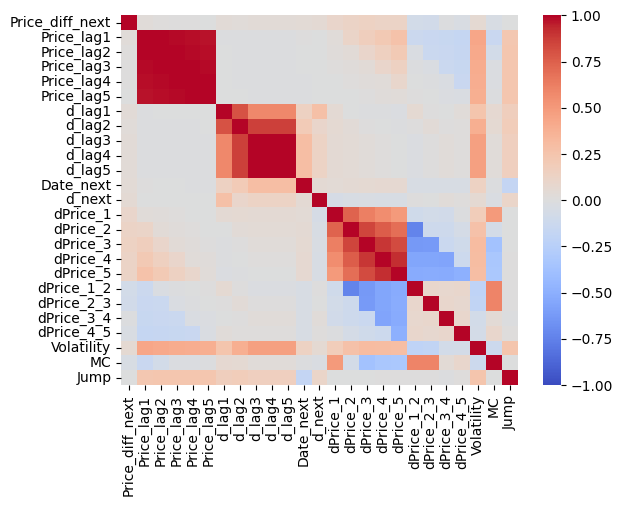

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    center=0,
    vmin=-1,
    vmax=1
)

plt.show()

According to this map, there is a strong correlation when it comes to data from days 3, 4, and 5, which is maybe why it was benefitial to take 4 and 5 out of the model.

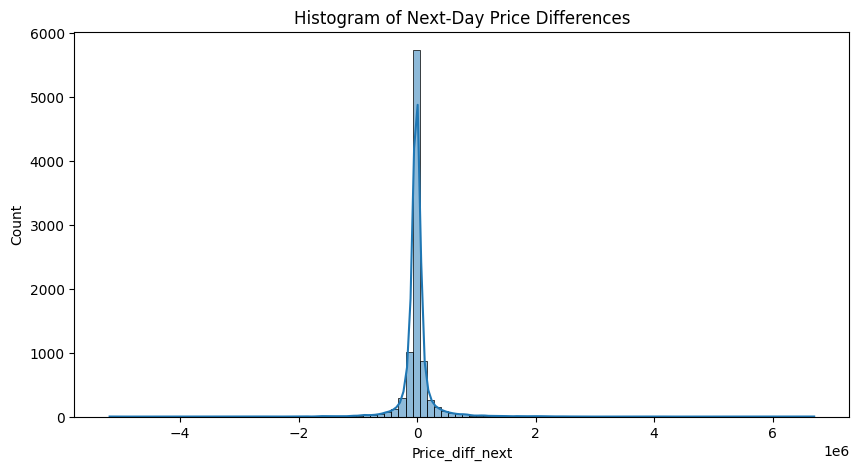

In [16]:
plt.figure(figsize=(10,5))
sns.histplot(df_t['Price_diff_next'], bins=100, kde=True)
plt.title("Histogram of Next-Day Price Differences")
plt.xlabel("Price_diff_next")
plt.ylabel("Count")
plt.show()

The target has mostly values around zero, which is small in comparison with other features such as the price, which can make it hard to predict. I think the wisest thing to do for now is to wait for more data or try other predictions. 

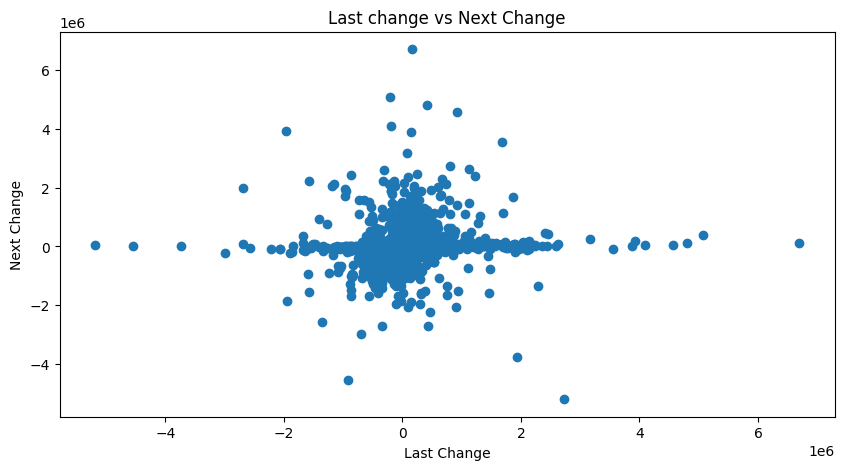

In [17]:
plt.figure(figsize=(10,5))
plt.scatter(df_t['dPrice_1'], df_t['Price_diff_next'])
plt.title("Last change vs Next Change")
plt.xlabel("Last Change")
plt.ylabel("Next Change")
plt.show()

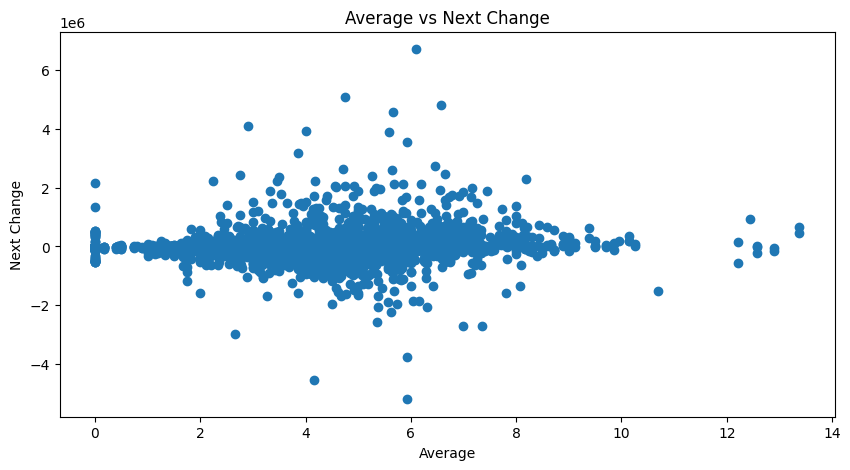

In [18]:
plt.figure(figsize=(10,5))
plt.scatter(df_t['Average'], df_t['Price_diff_next'])
plt.title("Average vs Next Change")
plt.xlabel("Average")
plt.ylabel("Next Change")
plt.show()

For now, I'll give RF a break and try with other models to test the performance. We now know there is a significant signal.

## XGBoost

Let's apply XGBoost to see if it's able to detect a stronger signal :) .

In [19]:
from xgboost import XGBRegressor

In [20]:
xgb = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=4,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.0,
    reg_alpha=0.0,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)

xgb.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

y_pred_xgb = xgb.predict(X_test)

r2_xgb = r2_score(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

print(f"XGBoost R²: {r2_xgb:.3f}, MAE: {mae_xgb:.2f}")

importances_xgb = pd.Series(
    xgb.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

print("\nXGBoost feature importances:")
print(importances_xgb)

XGBoost R²: 0.131, MAE: 54103.41

XGBoost feature importances:
Team_Manchester City           0.077798
Team_Crystal Palace            0.075173
d_next                         0.050201
GP                             0.049078
d_lag1                         0.046816
Home                           0.046002
Average                        0.042170
Price                          0.040878
Volatility                     0.039096
Team_Fulham                    0.038939
Team_Leeds United              0.038451
dPrice_1                       0.038010
dPrice_1_2                     0.036649
Team_Arsenal                   0.035805
Team_Chelsea                   0.035715
Team_Liverpool                 0.035399
d_lag2                         0.029223
MC                             0.028247
dPrice_2_3                     0.028159
Team_Newcastle                 0.026009
Team_Manchester United         0.025251
d_lag3                         0.023410
Team_Tottenham                 0.015299
Team_Everton     

XGBoost does well, but it's not as good as RF. 

So far, all of this has been just an attempt to find signal amongst a huge amount of noise. Now, I'll try a different approach: first determine if a jump will occur, and then predict how big will it be

## Two step regression

Let's go back to the distribution of the target, whose mean is -1.610395e+02:

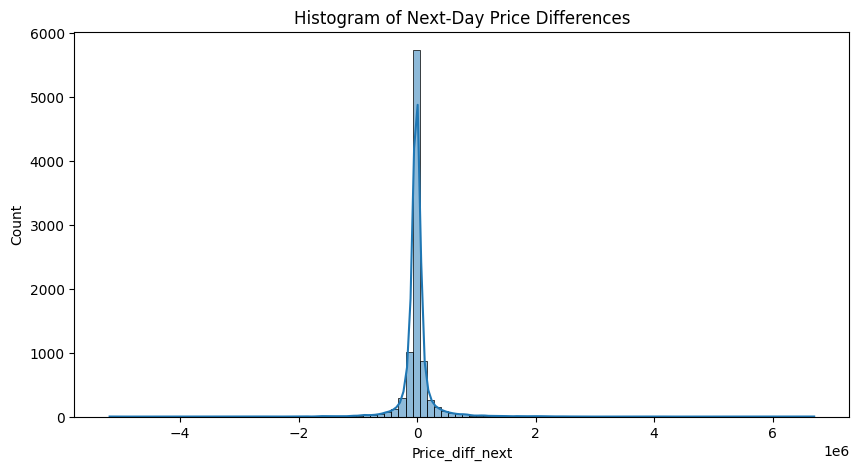

In [21]:
plt.figure(figsize=(10,5))
sns.histplot(df_t['Price_diff_next'], bins=100, kde=True)
plt.title("Histogram of Next-Day Price Differences")
plt.xlabel("Price_diff_next")
plt.ylabel("Count")
plt.show()

First step is to train the model to determine when a jump price is going to happen, no matter how small:

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV

threshold = 0

# New jump binary feature
df_t['Jump_next'] = (abs(df_t['Price_diff_next']) > threshold).astype(int)

# I'll keep the same features that worked before
X1 = X_rf
y1 = df_t['Jump_next']

#Date-based split
X1_train = X1.loc[train.index]
X1_test  = X1.loc[test.index]

y1_train = y1.loc[train.index]
y1_test  = y1.loc[test.index]

# Classifier
clf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

clf_jump_cal = CalibratedClassifierCV(
    clf,
    method='isotonic',
    cv=5
)

clf_jump_cal.fit(X1_train, y1_train)

# Probability for each row
p_jump_test = clf_jump_cal.predict_proba(X1_test)[:, 1]

# Performance score for the probability: probability of true jumps to have a higher predicted probability than true no-jumps
auc = roc_auc_score(y1_test, p_jump_test)
print(f"Stage 1 AUC: {auc:.3f}")

Stage 1 AUC: 0.748


0.71 seems to be strong :) .

Let's now train the model only on the rows that do present a true jump. That way, I can get reduce the sample of the target to only those rows who actually represent a jump and not take into account all the zeros that could be observed in the target's distribution. This leads to a more balanced prediction for the whole sample, given by

$ \Delta \text{Price}_{t+1} = P(\text{Jump}) \times \Delta \text{Price}_{t+1}^{\text{Jump}}$

In [23]:
#First we pick only the true jump rows from the training set
jump_mask_train = y1_train == 1

#Same as before
X2 = X1
y2 = df_t['Price_diff_next']

#The training set should only contain true jumps
X2_train = X2.loc[train.index][jump_mask_train]
y2_train = y2.loc[train.index][jump_mask_train]

#The test is on the whole sample
X2_test  = X2.loc[test.index]

#Regressor
reg = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

reg.fit(X2_train, y2_train)

#Predict the size of the jump assuming there's a jump
pred_size_test = reg.predict(X2_test)

#Weight the prediction with the probability of actually having a jump
y_pred_expected = p_jump_test * pred_size_test

#Mean absolute error for the weighted prediction
mae = mean_absolute_error(
    df_t.loc[test.index, 'Price_diff_next'],
    y_pred_expected
)

print(f"Two-stage MAE: {mae:.2f}")

#Mean absolute error considering raw predicted jump
jump_test_mask = df_t.loc[test.index, 'Jump_next'] == 1

mae_cond = mean_absolute_error(
    df_t.loc[test.index][jump_test_mask]['Price_diff_next'],
    y_pred_expected[jump_test_mask]
)

print(f"Conditional MAE (jump days): {mae_cond:.2f}")

Two-stage MAE: 50217.77
Conditional MAE (jump days): 60120.76


The MAE shows this model has potential, but does not outperform simple RF. 

Now let's try to keep stage 1 as it is, but change stage 2 to predict the direction (sign of the jump).

### Direction prediction

First, I'll calculate the probability of the price going up or down assuming a jump has occured.

In [25]:
#We keep the same training split, but we do need to change the target

df_t['dir_next'] = (df_t['Price_diff_next'] > 0).astype(int)

#Work only with rows with a jump

jump_mask_2 = df_t['Price_diff_next'] != 0

y = df_t['dir_next']

X_train = X2.loc[train.index][jump_mask_2.loc[train.index]]
y_train = y.loc[train.index][jump_mask_2.loc[train.index]]

X_test  = X2.loc[test.index][jump_mask_2.loc[test.index]]
y_test  = y.loc[test.index][jump_mask_2.loc[test.index]]

#Regressor
clf_2 = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=5,
    class_weight = 'balanced',
    random_state=42,
    n_jobs=-1
)

clf_dir_cal = CalibratedClassifierCV(
    clf_2,
    method='isotonic',
    cv=5
)

clf_dir_cal.fit(X_train, y_train)

#Predict the direction of the jump
p_up = pd.Series(clf_dir_cal.predict_proba(X_test)[:, 1], index=X_test.index)

#Compute the weighted probability

p_jump_test = pd.Series(
    p_jump_test,
    index=test.index)

p_jump = p_jump_test.loc[jump_mask_2]

P_up   = p_jump * p_up
P_down = p_jump * (1 - p_up)
P_zero = 1 - p_jump

pred = pd.concat([P_down, P_zero, P_up], axis=1)
pred.columns = ['down', 'zero', 'up']

# Performance score for the probability
auc = roc_auc_score(y_test, p_up)
print(f"AUC: {auc:.3f}")

AUC: 0.835


That is very good ranking. Let's evaluate the two probabilities individually:

In [27]:
from sklearn.metrics import log_loss
print(log_loss(y1_test, p_jump_test))
print(log_loss(y_test, p_up))

0.5654353194071892
0.6144976781090504


That is good. Probabilities are meaningful. Now the joint probability:

In [29]:
import numpy as np

P = np.column_stack([
    P_up,     # jump * P(up|jump)
    P_down,   # jump * P(down|jump)
    P_zero    # 1 - jump
])

dir_map_3 = {
    1:  0,   # up
   -1:  1,   # down
    0:  2    # zero / no jump
}

y_true_3class = df_t['dir_next'].map(dir_map_3)

log_loss(y_true_3class.loc[y_test.index], P, labels=[0, 1, 2])

1.335891899493918

This means a joint probability does not work well, at least with log_loss. What works well is separating the jump probability from the conditional up / down probability. I need to look further into the reasons of this, but I would say it is possible to forecast the direction of the price change with this model.

I also tried to perform a one-stage prediction:

In [34]:
import numpy as np

#We keep the same training split, but we do need to change the target

df_t['dir_next'] = np.sign(df_t['Price_diff_next'])

#Map for classifier

dir_map = {-1: 0, 0: 1, 1: 2}
y = df_t['dir_next'].map(dir_map)

#Keep the entire sample

X_train = X2.loc[train.index]
y_train = y.loc[train.index]

X_test  = X2.loc[test.index]
y_test  = y.loc[test.index]

#Regressor
clf_2 = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

clf_dir_cal = CalibratedClassifierCV(
    clf_2,
    method='isotonic',
    cv=5
)

clf_dir_cal.fit(X_train, y_train)

#Predict the direction of the jump
proba = clf_dir_cal.predict_proba(X_test)

from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, clf_dir_cal.predict(X_test)))
print(confusion_matrix(y_test, clf_dir_cal.predict(X_test)))

log_loss(y_test, proba, labels=[0,1,2])

              precision    recall  f1-score   support

           0       0.55      0.66      0.60       629
           1       0.34      0.74      0.47       237
           2       1.00      0.00      0.00       409

    accuracy                           0.47      1275
   macro avg       0.63      0.47      0.36      1275
weighted avg       0.65      0.47      0.38      1275

[[417 212   0]
 [ 62 175   0]
 [282 126   1]]


1.0875863492029156

Again, I'm not completely sure why this classifier struggles this much according to log_loss. It's not completely useless, but it's not great. For now I'll stick to the two-stage alternative.

## Conclusions

1. I have achieved a decent way to predict how much the price will shift. Simple RF is the best alternative, with a MAE of 51710.32 and R² higher than 0.19. The two-stage model is also very promising, but does not perform as well.
2. The two-stage model for jump direction does carry a good signal, and probabilities seem to be actually useful. However, the joint distribution does not behave well with log_loss. It needs to be tested by more metrics and will probably lead to a more sophisticated model.

## What's next for this project?
1. To improve forecasting, I first need to wait for more data.
2. When the season ends, I would like to implement a feature that classifies dates into stages of the season (e.g. pre-season, early-season, mid-season, late-season, December). This could help predictions when there is no performance updates.
3. I would like to dive into trading strategies and decision making metrics, but I first need a better understanding of it.
4. It would be interesting to elaborate an interface showing the predictions achieved here, but daily, for every player.